# **APPENDIX A: DATA CLEANING**

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import scipy.stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
#mount drive for data files 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
temp = pd.read_excel('/content/drive/MyDrive/AAI500/Project/Dataset.xlsx')
temp.head()

,Trip,Date,Route/Area,Weather,Battery Temperature (Start) [°C],Battery Temperature (End),Battery State of Charge (Start),Battery State of Charge (End),Unnamed: 8,Ambient Temperature (Start) [°C],Target Cabin Temperature,Distance [km],Duration [min],Unnamed: 13,Fan,Note
0,TripA01,2019-06-25_13-21-14,Munich East,sunny,21.0,22.0,0.863,0.803,0.060,25.5,23.0,7.427690,16.820000,NaN,"Automatic, Level 1",NaN
1,TripA02,2019-06-25_14-05-31,Munich East,sunny,23.0,26.0,0.803,0.673,0.130,32.0,23.0,23.509709,23.550000,NaN,"Automatic, Level 1",Target Cabin Temperature changed
2,TripA03,2019-06-28_10-02-15,Munich East,sunny,24.0,25.0,0.835,0.751,0.084,21.5,27.0,12.820846,11.180000,NaN,"Automatic, Level 1",Target Cabin Temperature changed
3,TripA04,2019-06-28_10-13-30,Munich East,sunny,25.0,27.0,0.751,0.667,0.084,24.0,22.0,10.727491,6.870000,NaN,"Automatic, Level 1",NaN
4,TripA05,2019-06-28_10-20-26,Munich East,sunny,27.0,27.0,0.667,0.602,0.065,24.5,24.0,12.393223,22.776667,NaN,"Automatic, Level 1",NaN


In [4]:
#remove empty rows and columns
temp = temp.dropna(how = 'all', axis = 0)
temp = temp.dropna(how = 'all', axis = 1)

In [5]:
#Make weather column numerical 
#Sunset=7, Sunrise=6, Sunny=5, slightly cloudy=4, rainy=3, =2, dark=1, cloudy=0
temp['Weather'] = temp['Weather'].astype('category')
temp['Weather'] = temp['Weather'].cat.codes

In [6]:
#rename column
temp.rename(columns={'Unnamed: 8':'delta_SOC'}, inplace=True)
#check if better was charged 
temp.drop(temp[temp['delta_SOC'] < 0].index, inplace=True)
#Find rate of SOC
temp['SOC_rate']=(temp['delta_SOC'])/temp['Duration [min]']
#Find heating rate 
temp['heat_rate']=(temp['Battery Temperature (End)']-temp['Battery Temperature (Start) [°C]'])/temp['Duration [min]']
temp.head()

,Trip,Date,Route/Area,Weather,Battery Temperature (Start) [°C],Battery Temperature (End),Battery State of Charge (Start),Battery State of Charge (End),delta_SOC,Ambient Temperature (Start) [°C],Target Cabin Temperature,Distance [km],Duration [min],Fan,Note,SOC_rate,heat_rate
0,TripA01,2019-06-25_13-21-14,Munich East,5,21.0,22.0,0.863,0.803,0.060,25.5,23.0,7.427690,16.820000,"Automatic, Level 1",NaN,0.003567,0.059453
1,TripA02,2019-06-25_14-05-31,Munich East,5,23.0,26.0,0.803,0.673,0.130,32.0,23.0,23.509709,23.550000,"Automatic, Level 1",Target Cabin Temperature changed,0.005520,0.127389
2,TripA03,2019-06-28_10-02-15,Munich East,5,24.0,25.0,0.835,0.751,0.084,21.5,27.0,12.820846,11.180000,"Automatic, Level 1",Target Cabin Temperature changed,0.007513,0.089445
3,TripA04,2019-06-28_10-13-30,Munich East,5,25.0,27.0,0.751,0.667,0.084,24.0,22.0,10.727491,6.870000,"Automatic, Level 1",NaN,0.012227,0.291121
4,TripA05,2019-06-28_10-20-26,Munich East,5,27.0,27.0,0.667,0.602,0.065,24.5,24.0,12.393223,22.776667,"Automatic, Level 1",NaN,0.002854,0.000000


# **APPENDIX B: EXPLORATORY DATA ANALYSIS**

In [7]:
#scatter plot for relevant features
def feature_plots(df, columns, num_cols):
    n_plots = len(columns)
    n_cols = num_cols
    n_rows = int(math.ceil(n_plots/n_cols))
    gs = gridspec.GridSpec(n_rows, n_cols)
    fig = plt.figure(figsize=(25,20))
    plt.rcParams.update({'font.size': 18})
    for i in range(n_plots):
        ax = fig.add_subplot(gs[i])
        x = df[columns[i]]
        y = df['heat_rate']
        m, b = np.polyfit(x, y, 1)
        plt.scatter(x, y)
        plt.plot(x, m*x+b, color = 'red')
        ax.set_xlabel(columns[i])
        ax.set_ylabel('Battery Heating Rate [°C/min]')
        ax.set_title('{} vs. {};'.format(columns[i], 'Battery Heating Rate [°C/min]'))
    fig.tight_layout()
    plt.show()

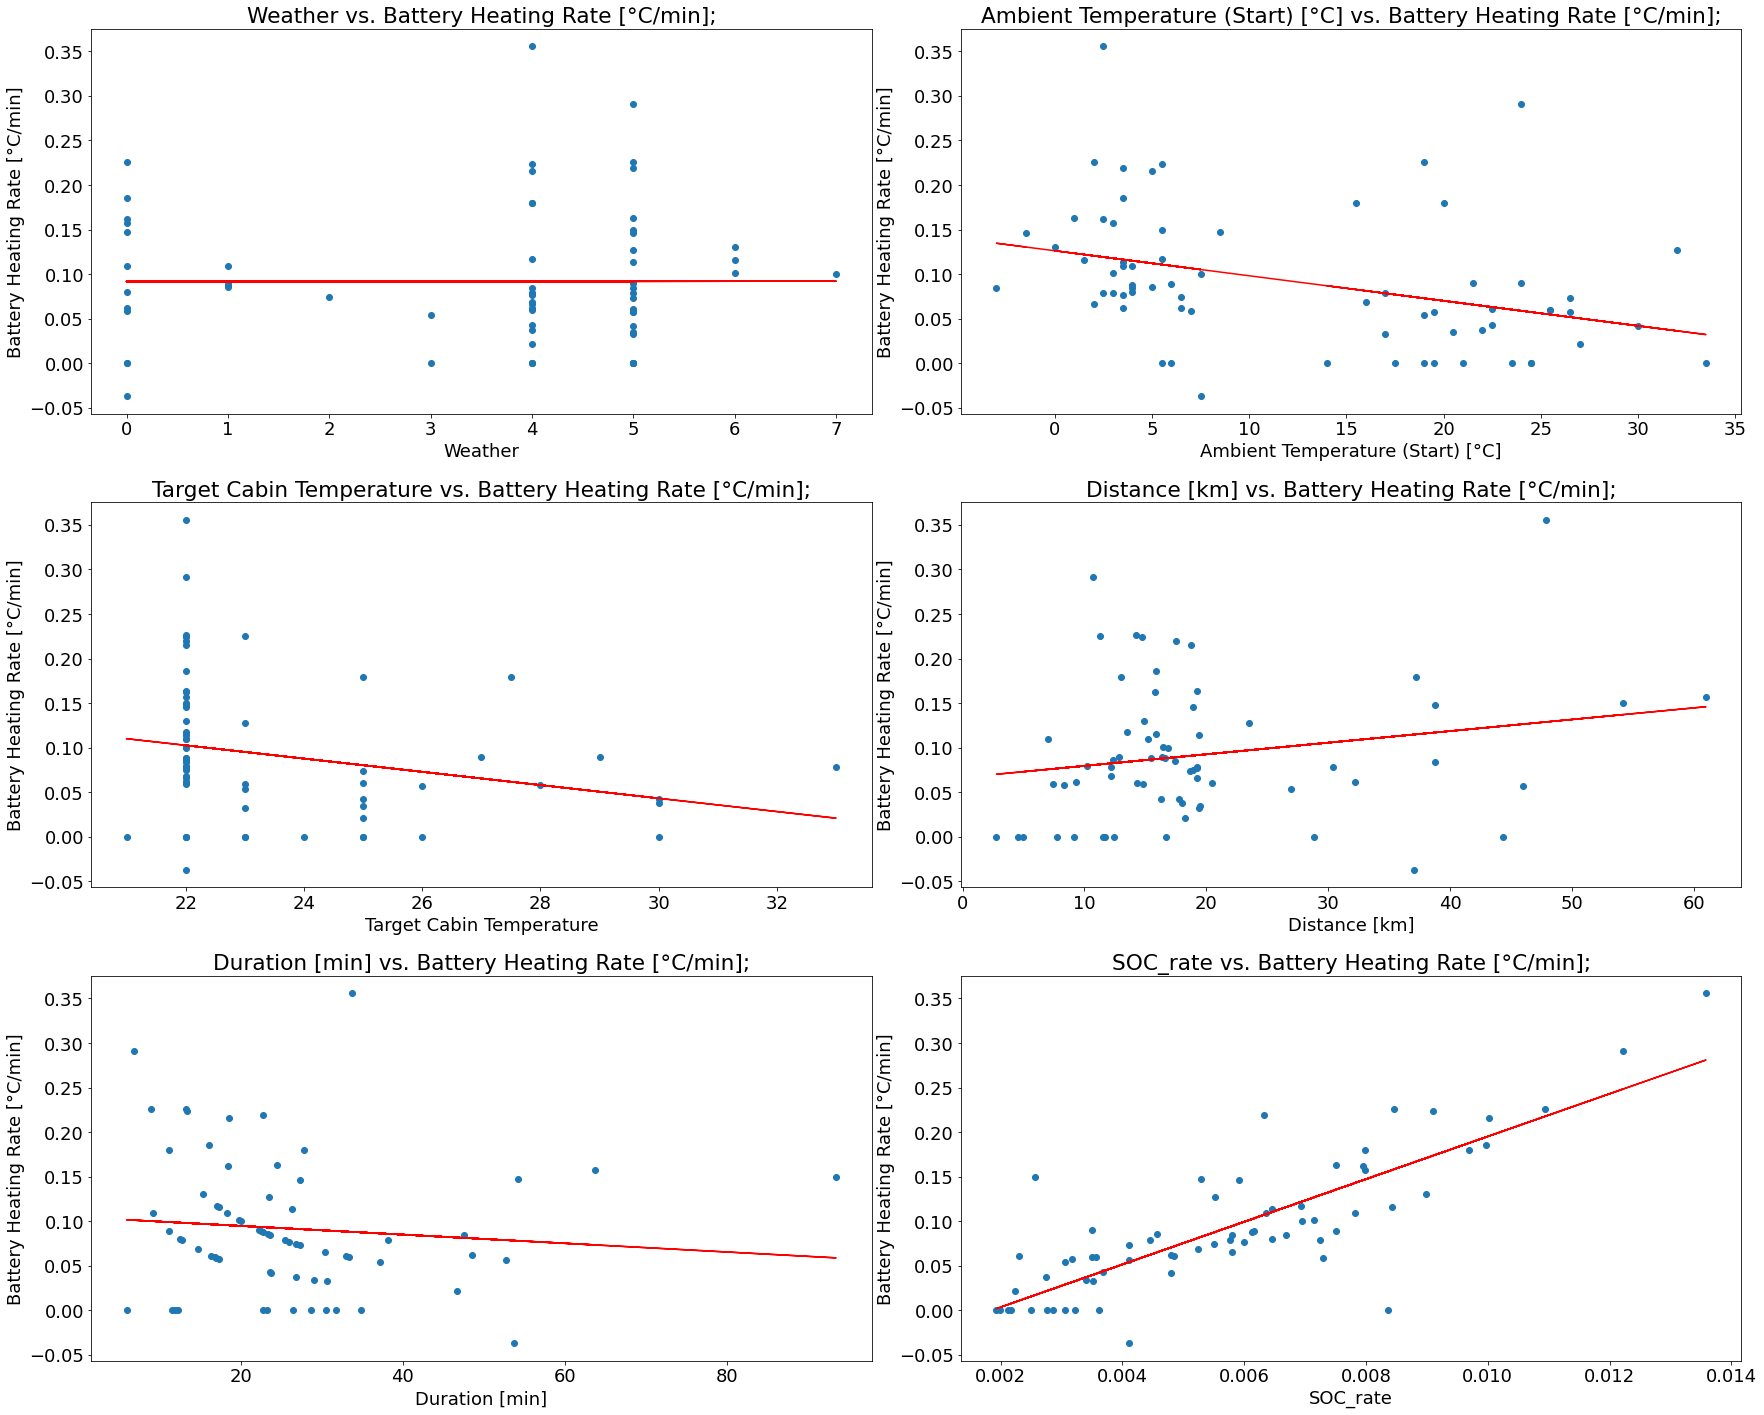

In [8]:
feature_plots(temp, ['Weather','Ambient Temperature (Start) [°C]', 'Target Cabin Temperature', 'Distance [km]', 'Duration [min]', 'SOC_rate'], 2)

In [9]:
#Create new dataframe with the features from scatter plot
temp = temp[['heat_rate', 'Weather', 'Ambient Temperature (Start) [°C]', 'Target Cabin Temperature', 'Distance [km]', 'Duration [min]', 'SOC_rate']].copy()

In [10]:
#correlation table 
temp.corr()

,heat_rate,Weather,Ambient Temperature (Start) [°C],Target Cabin Temperature,Distance [km],Duration [min],SOC_rate
heat_rate,1.000000,0.001720,-0.365456,-0.246206,0.201241,-0.094280,0.827180
Weather,0.001720,1.000000,0.398292,0.300759,-0.063356,-0.041110,-0.088704
Ambient Temperature (Start) [°C],-0.365456,0.398292,1.000000,0.598549,-0.063120,-0.013654,-0.397338
Target Cabin Temperature,-0.246206,0.300759,0.598549,1.000000,-0.044374,-0.051135,-0.212821
Distance [km],0.201241,-0.063356,-0.063120,-0.044374,1.000000,0.839709,0.170794
Duration [min],-0.094280,-0.041110,-0.013654,-0.051135,0.839709,1.000000,-0.261755
SOC_rate,0.827180,-0.088704,-0.397338,-0.212821,0.170794,-0.261755,1.000000


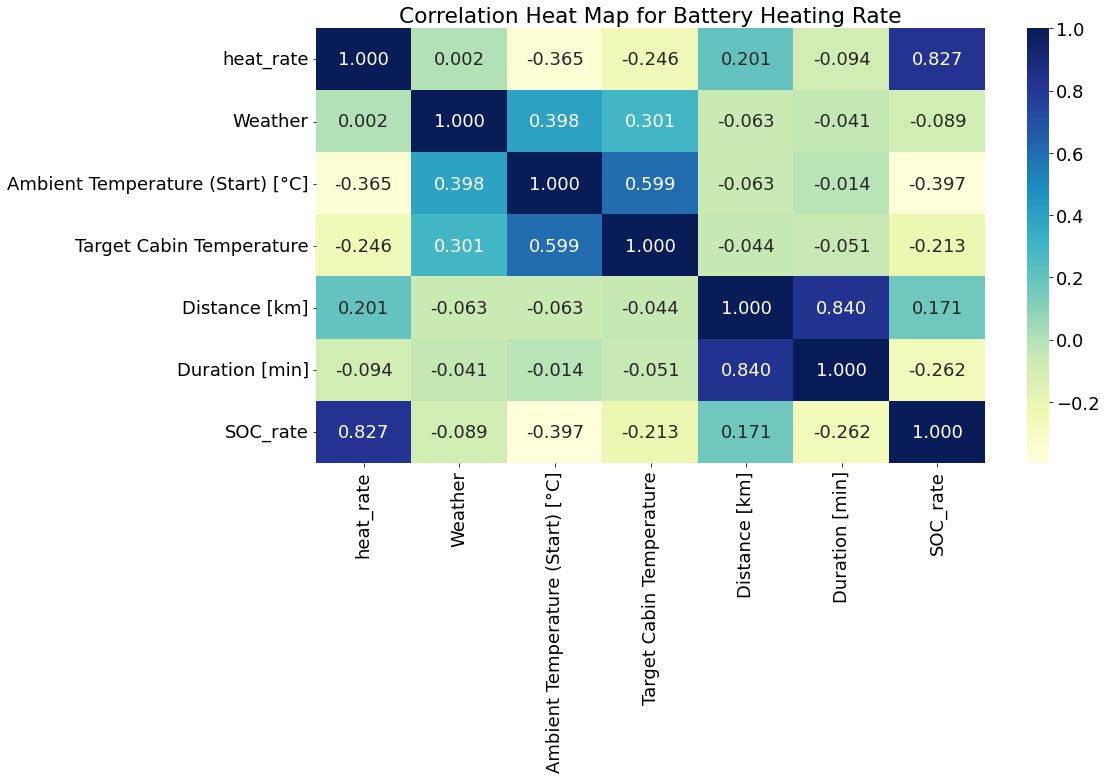

In [11]:
plt.figure(figsize=(15,8))
sns.heatmap(temp.corr(),annot=True, fmt='0.3f', cmap='YlGnBu')
plt.title('Correlation Heat Map for Battery Heating Rate')
plt.show()

In [12]:
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
heat_rate,68.0,0.091763,0.076233,-0.037204,0.042277,0.078644,0.128122,0.355872
Weather,68.0,3.558824,1.995385,0.000000,2.750000,4.000000,5.000000,7.000000
Ambient Temperature (Start) [°C],68.0,12.250000,9.915878,-3.000000,3.500000,7.250000,21.125000,33.500000
Target Cabin Temperature,68.0,23.448529,2.523235,21.000000,22.000000,22.000000,25.000000,33.000000
Distance [km],68.0,19.444819,11.775561,2.782300,12.380818,16.502600,19.377591,60.974700
Duration [min],68.0,25.816225,14.725627,5.906667,16.689583,23.465000,30.420417,93.501667
SOC_rate,68.0,0.005689,0.002632,0.001932,0.003506,0.005645,0.007352,0.013582


# **APPENDIX C: MODEL SELECTION AND ANALYSIS**

In [13]:
#Independent variables, dependent variable, respectively
x = temp.loc[:, temp.columns != 'heat_rate']
y = pd.DataFrame(temp['heat_rate'])

                            OLS Regression Results                            
Dep. Variable:              heat_rate   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     21.18
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           5.27e-11
Time:                        21:39:04   Log-Likelihood:                 94.298
No. Observations:                  47   AIC:                            -174.6
Df Residuals:                      40   BIC:                            -161.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

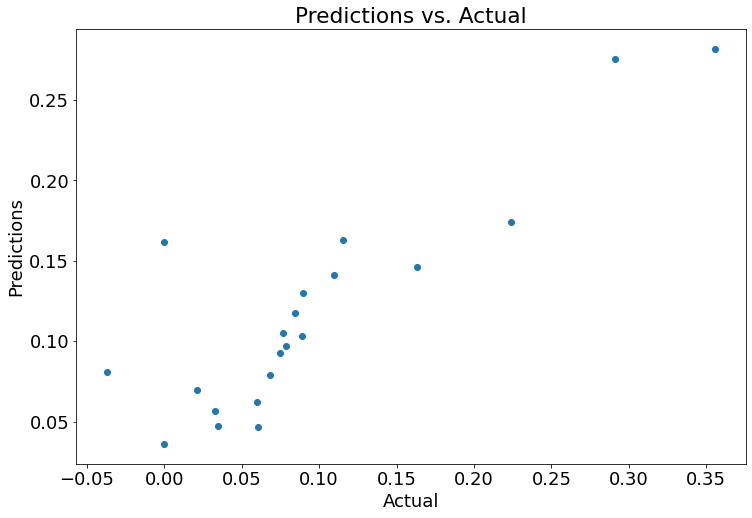

In [14]:
#Train/test split 1
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=10)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())
#Plot predicted values vs. actual test values
y_pred = model.predict(X_test)
fig = plt.figure(figsize=(12,8))
plt.scatter(y_test, y_pred)
plt.title('Predictions vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

                            OLS Regression Results                            
Dep. Variable:              heat_rate   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     34.02
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           3.21e-14
Time:                        21:39:04   Log-Likelihood:                 94.952
No. Observations:                  47   AIC:                            -175.9
Df Residuals:                      40   BIC:                            -163.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

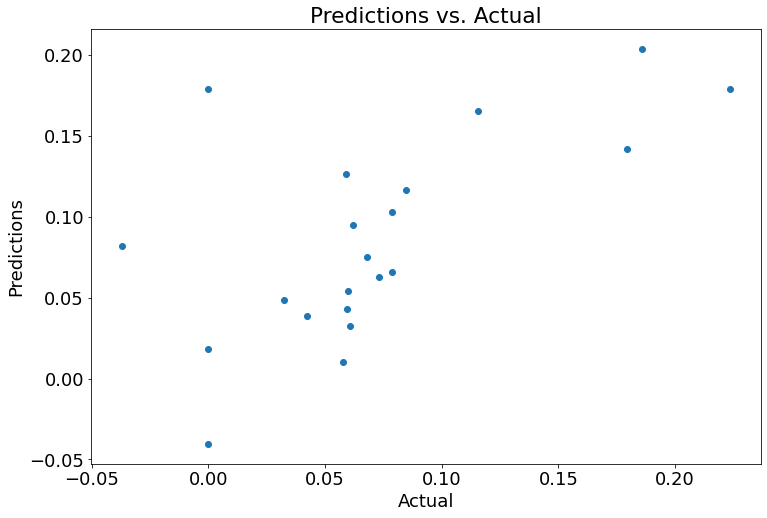

In [15]:
#Train/test split 2
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=38)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())
#Plot predicted values vs. actual test values
y_pred = model.predict(X_test)
fig = plt.figure(figsize=(12,8))
plt.scatter(y_test, y_pred)
plt.title('Predictions vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

                            OLS Regression Results                            
Dep. Variable:              heat_rate   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     27.63
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           9.12e-13
Time:                        21:39:04   Log-Likelihood:                 93.355
No. Observations:                  47   AIC:                            -172.7
Df Residuals:                      40   BIC:                            -159.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

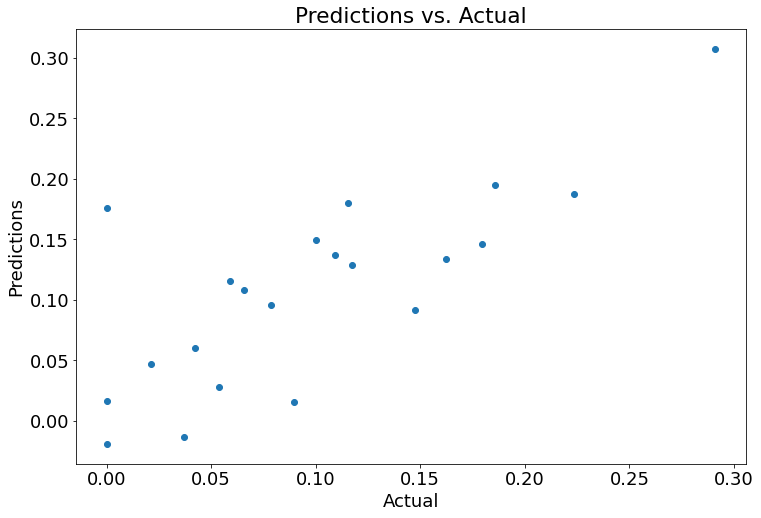

In [16]:
#Train/test split 3
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=99)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())
#Plot predicted values vs. actual test values
y_pred = model.predict(X_test)
fig = plt.figure(figsize=(12,8))
plt.scatter(y_test, y_pred)
plt.title('Predictions vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

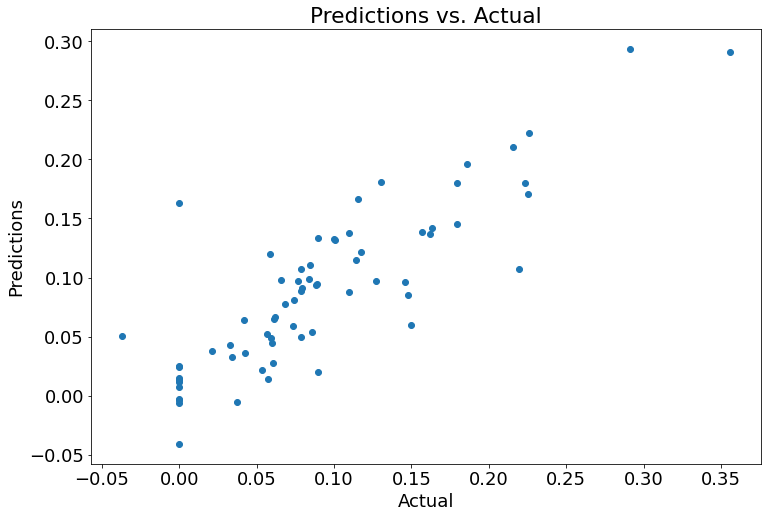

In [17]:
#Final model
x1 = temp['Weather']
x2 = temp['Ambient Temperature (Start) [°C]']
x3 = temp['Target Cabin Temperature']
x4 = temp['Distance [km]']
x5 = temp['Duration [min]']
x6 = temp['SOC_rate']
y_calc = -0.053+0.003*x1+0.001*x2-0.003*x3-0.002*x4+0.002*x5+31.201*x6

fig = plt.figure(figsize=(12,8))
plt.scatter(temp['heat_rate'], y_calc)
plt.title('Predictions vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

In [18]:
for i in range(0,69):
  diff = abs(y_calc-temp['heat_rate'])

print(diff.max())
print(diff.min())

0.1627526195722658
0.0006944407417486254


In [19]:
z = 1.96
n = len(y_calc)
mean = np.mean(y_calc)
std = np.std(y_calc)
stderr = std/(np.sqrt(n))

CI1 = mean-1.96*stderr
CI2 = mean+1.96*stderr

print('The 95% confidence interval for the rate at which the battery heats up is:', round(CI1,2), 'and', round(CI2,2))

The 95% confidence interval for the rate at which the battery heats up is: 0.07 and 0.11
